# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import random

from sklearn.metrics import classification_report

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [4]:
df.email.nunique(), df.article_id.nunique()

(5148, 714)

In [5]:
dist_df = df.groupby(['email']).count()['title'].reset_index().rename(columns = {'title': 'count'})

In [6]:
dist_df.head()

,email,count
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [7]:
dist_df['count'].describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: count, dtype: float64

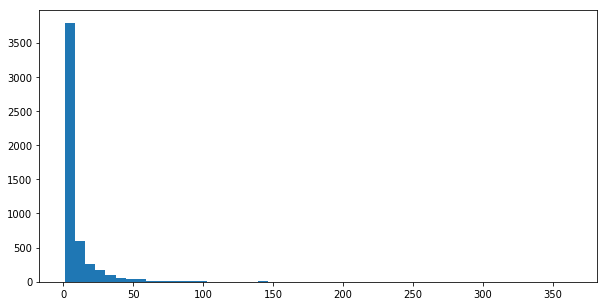

In [8]:
plt.figure(figsize=(10,5))
plt.hist(dist_df['count'], bins=50);

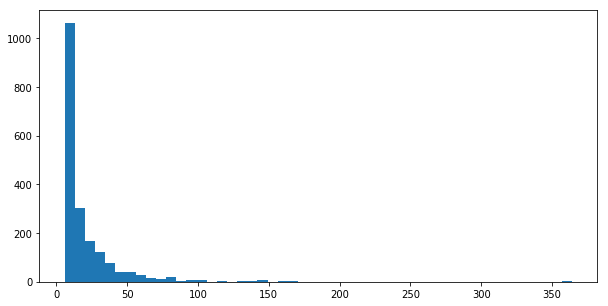

In [9]:
plt.figure(figsize=(10,5))
plt.hist(dist_df[dist_df['count'] > 5]['count'], bins=50);

In [10]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = int(dist_df['count'].median())
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = int(dist_df['count'].max())

print("50% of individuals interact with {} number of articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles

df_content.shape[0], df_content.article_id.nunique(), df_content.doc_full_name.nunique()

(1056, 1051, 1051)

In [12]:
df_content[df_content.duplicated(['article_id'], keep=False)].sort_values(by=['article_id'])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
df_content.shape

(1051, 5)

In [14]:
df_content.article_id.nunique()

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
df.shape


(45993, 3)

In [16]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [17]:
df.email.nunique()

5148

The number of unique users is 5148.

In [18]:
df.article_id.nunique()

714

The number of unique articles with some iteraction registered from the users is 714. 

In [19]:
df_new = df.copy()
df_new.article_id = df_new.article_id.astype(int)

In [20]:
articles_not_seen = np.setdiff1d(np.array(df_content.article_id), np.array(df_new.article_id), assume_unique=True)
old_articles = np.setdiff1d(np.array(df_new.article_id), np.array(df_content.article_id), assume_unique=True)
len(articles_not_seen), len(old_articles)


(614, 277)

There are 600 articles in df_content without any interaction and there are 277 articles that have been read but they are non longer in the list of content. These are surely old articles that they are not available now.

In [21]:
df.groupby(['email', 'article_id']).ngroups

33669

The total number of interactions between the users and the articles is 33669

In [22]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()
# The number of unique users
unique_users = df.email.nunique()
# The number of user-article interactions
user_article_interactions = df.shape[0]

In [23]:
print("There are {} unique articles that have at least one interaction.".format(unique_articles))
print("There are {} unique articles in total on the IBM platform.".format(total_articles))
print("There are {} unique users.".format(unique_users))
print("There are {} user-article interactions.".format(user_article_interactions))

There are 714 unique articles that have at least one interaction.
There are 1051 unique articles in total on the IBM platform.
There are 5148 unique users.
There are 45993 user-article interactions.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [24]:
max_item = df.groupby(['article_id']).count()['title']. \
           sort_values(ascending=False).reset_index(). \
           rename(columns = {'title': 'count'}).iloc[0:5]

In [25]:
max_item

,article_id,count
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [26]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = str(max_item['article_id'][0])
# The most viewed article in the dataset was viewed how many times?
max_views = max_item['count'][0]
 

In [27]:
print("The most viewed article in the dataset was {}.".format(most_viewed_article_id))
print("The most viewed article in the dataset was viewed was viewed {} times.".format(max_views))

The most viewed article in the dataset was 1429.0.
The most viewed article in the dataset was viewed was viewed 937 times.


In [28]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
user_id       45993 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [30]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [31]:
n = 10
top_articles = df['article_id'].value_counts().index[:n].tolist()

In [32]:
top_articles

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [33]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index[:n].tolist()
    top_articles = [str(x) for x in top_articles]
 
    return top_articles # Return the top article ids

def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_ids = get_top_article_ids(n, df)
    top_articles = df[df['article_id'].isin(top_articles_ids)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)



In [34]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [35]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [36]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item =  df[['user_id', 'article_id']]
    user_item['interact'] = 1
    user_item = user_item.groupby(['user_id', 'article_id'])['interact'].max().unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [37]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [38]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_product = np.dot(user_item.loc[user_id], np.transpose(user_item))
    similarities = pd.DataFrame({'user_id': user_item.index.values, 'similarity': dot_product})

    # sort by similarity 
    similarities = similarities.sort_values(by = ['similarity'], ascending = False)

    # create list of just the ids  
    most_similar_users = list(similarities.user_id)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    # return a list of the users in order from most to least similar
    return most_similar_users 
        

In [39]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [40]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
user_item.loc[[2]]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
def get_article_names(article_ids, df=df, df_content = df_content):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    # convert to float the list of article_ids and get the title from the dataframe df
    df_aux = df_content[['article_id', 'doc_full_name']].rename(columns = {'doc_full_name': 'title'})
    df_aux = df[['article_id', 'title']].append(df_aux[~df_aux.article_id.isin(df.article_id)])
    article_ids = list(map(float, article_ids))
    for article in article_ids:
        article_names.append(df_aux[df_aux.article_id == article]['title'].unique()[0])
    #article_names = list(df_aux[df_aux.article_id.isin(article_ids)]['title'].unique())
    # Return the article names associated with list of article ids
    return article_names 


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # select the row of user_item from the user user_id
    articles = user_item.loc[[user_id]]
    
    # get a list with the columns (article_ids) with some interaction 
    article_ids = list(articles[(articles == 1)].dropna(axis = 1).columns)
    
    # convert to string and get the title of the article from the dataframe df.
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # get the list of similar users to user_id
    similar_users = find_similar_users(user_id, user_item)
    recs = []
    article_ids = []
    article_name = []
    
    # obtain the articles that have already been read by the user user_id
    article_ids_user, article_names_user = get_user_articles(user_id, user_item)
    
    # for each one of the similar users...
    for user in similar_users:
        # get the articles that the user has read
        article_ids, article_names = get_user_articles(user, user_item)
        
        # select only the articles that user_id has not read
        article_ids = [x for x in article_ids if x not in article_ids_user]
        
        # select those articles that are not already in recs
        article_ids = [x for x in article_ids if x not in recs]
        
        # add the resulting articles to a list
        recs = recs + article_ids
        
        # it the length of the list is greater than m then select the first m and exit.
        if len(recs) >= m:
            recs = recs[0:m]
            break
    
    # return your recommendations for this user_id 
    return recs    

In [43]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [44]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [45]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [46]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user using the dot product
    dot_product = np.dot(user_item.loc[user_id], np.transpose(user_item))
    neighbors_df = pd.DataFrame({'user_id': user_item.index.values, 
                                 'similarity': dot_product}).set_index('user_id')
    
    # we do de calculation of the number of interactions for each user. 
    interactions = df.groupby(['user_id']).count()['article_id']
    
    # we add a new column with the number of interactions
    neighbors_df['num_interactions'] = interactions
    
    # we drop the user_id from this dataframe
    neighbors_df = neighbors_df.drop(user_id)

    # sort the dataframe neighbors_df by 'similarity' and 'num_interactions'
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def get_sorted_neighbor_articles(user_id, top_article_ids):
    """
    INPUT:
    user_id - (int) a user id
    top_article_ids - a list of article ids sorted by the number of interactions 
                      in descending order

    Output:
    recs: (list) a list of articles for the user sorted by articles' overall number of interactions

    """

    final_article_ids, _ = get_user_articles(user_id)

    article_sort_id = []

    for article_id in final_article_ids:
        article_sort_id.append(top_article_ids.index(article_id))

    final_user_top_articles = sorted(zip(final_article_ids, article_sort_id), key=lambda x: x[1])
    final_user_top_articles = [x[0] for x in final_user_top_articles]

    # append required number of articles to the recommendation list
    recs = final_user_top_articles

    return recs



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    neighbors_df = get_top_sorted_users(user_id)
    recs = []
    rec_names = []
    article_ids = []
    article_name = []
    
    # order articles by interactions
    ordered_articles_inter = df.groupby(['article_id'])['user_id'].count().sort_values(ascending = False)
    ordered_articles_inter = list(ordered_articles_inter.index)
    ordered_articles_inter = [str(i) for i in ordered_articles_inter]
    
    # get the articles readed by the user
    article_ids_user, article_names_user = get_user_articles(user_id)
    
    # for each user in neighbors_df
    for user in list(neighbors_df.index):
        # get the articles read by user ordered by number of readings
        article_ids = get_sorted_neighbor_articles(user, ordered_articles_inter)
        
        # select those articles that user_id has not read
        article_ids = [x for x in article_ids if x not in article_ids_user]
        
        # select those articles that are not already in recs
        article_ids = [x for x in article_ids if x not in recs]
        
        # add the result to a list
        recs = recs + article_ids
        
        # if the list has mor than m elements, we get the first m elements and we exit
        if len(recs) >= m:
            recs = recs[0:m]
            break
    
    # get the article names
    rec_names = get_article_names(recs)
    
    
    return recs, rec_names

In [48]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1427.0', '1364.0', '1170.0', '1162.0', '1304.0', '1351.0', '1160.0', '1354.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [49]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim =  get_top_sorted_users(1).index[0]
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).index[9]

In [50]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

In [51]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}
t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**If we are given a new user, we don't have any information about him. We only can use a rank based method from the functions we have developed avobe. We could include some kind of filter and implement a knowledge based method to start to get inforamtion about this user and apply a collaborative filter later.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10)

We can only use a rank based method, so we recommend the top 10 articles.

In [53]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [54]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [55]:


import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

The dataframe used to do the content analysis is going to be `df_content`.

In [56]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [57]:
df_content.doc_status.value_counts()

Live    1051
Name: doc_status, dtype: int64

In [58]:
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [59]:
null_desc = df_content[df_content.doc_description.isnull() == True]
null_desc

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,NaN,Build the search index in Cloudant,Live,354
768,Compose The Compose logo Articles Sign in Free...,NaN,Announcing the Data Browser for JanusGraph,Live,765
919,Cloudant Query is a powerful declarative JSON ...,NaN,Use the new Cloudant query,Live,916


In [60]:
null_body = df_content[df_content.doc_body.isnull() == True]
null_body

,doc_body,doc_description,doc_full_name,doc_status,article_id
206,NaN,Watch how to convert XML data to CSV format to...,Load XML data into dashDB,Live,206
276,NaN,Love to work in Microsoft Excel? Watch how to ...,Integrate dashDB with Excel,Live,276
484,NaN,See how to evaluate and convert your DDL and S...,Convert IBM Puredata for Analytics to dashDB,Live,483
508,NaN,Watch how to generate SQL-based reports for Cl...,Use dashDB with IBM Embeddable Reporting Service,Live,507
540,NaN,Need to move some data to the cloud for wareho...,Convert data from Oracle to dashDB,Live,539
638,NaN,See how to create a new dashDB instance and po...,Load JSON from Cloudant database into dashDB,Live,637
667,NaN,"See how to connect dashDB, as a source and tar...",Integrate dashDB and Informatica Cloud,Live,666
706,NaN,Aginity Workbench is a free application known ...,Use Aginity Workbench for IBM dashDB,Live,704
842,NaN,Learn how to configure a dashDB connection in ...,Leverage dashDB in Cognos Business Intelligence,Live,839
876,NaN,See how to populate data into a table in your ...,Load data from the desktop into dashDB,Live,873


We have three columns with text that we can use to analyze the content: `doc_body`, `doc_description` and `doc_full_name`. We are going to use `doc_description` and `doc_full_name` because they are like a summary of the content of the article.

There are 14 articles without data in the `doc_body` column, we could try to find out the reason and fill in these columns if we had more information, but in this case it does not make sense to recommend an article without a body, so we are going to drop out these rows.

In [61]:
df_content_new = df_content[df_content.doc_body.isnull() != True]

Regarding the rows with no information in the `doc_description` column we are going to replace the `NaN` value by an empty string. We don't have a description of the document, but we ca use the name to try to extract the content and make recommendations with it. Let's see if it is enough.

In [62]:
df_content_new.doc_description.fillna('', inplace=True)

C:\Users\jesus\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [63]:
df_content_new.iloc[np.where(df_content_new['doc_description'] == '')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
354,The search index lets you create flexible quer...,,Build the search index in Cloudant,Live,354
768,Compose The Compose logo Articles Sign in Free...,,Announcing the Data Browser for JanusGraph,Live,765
919,Cloudant Query is a powerful declarative JSON ...,,Use the new Cloudant query,Live,916


In [64]:
def tokenize(text):
    '''
    INPUT:
    text - (str) the string we want to apply the tokenization
    
    OUTPUT:
    clean_tokens - (list) a list with the tokens of the estring
    
    Description:
    Extract tokens fron a string and apply a lemmatization and a stem process.
    '''
    # replace all the chars not in a-z, A-Z or 0-9 by " "
    #text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # tokenize the text and drop the the stop words in Enghish
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    # initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()  
    stemmer = SnowballStemmer("english")
    #stemmer = PorterStemmer()

    # lemmatize each token and return a list of lower lematized tokens
    clean_tokens = []
    for tok in tokens:
        # lemmtize token using noun as part of speech
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        # stem the token
        clean_tok = stemmer.stem(clean_tok)
        # append the token to clean_tokens
        clean_tokens.append(clean_tok)

    return clean_tokens

In [65]:
def tfidf_transformer(data, index, tokenizer=tokenize):
    '''
    INPUT:
    data - (Series) the column of a dataframe in which we want to calculate the tfidf matrix
    index - (Series) The column of a dataframe to be the index of the result tfidf dataframe
    tokenizer - (function) The function we want to use to do the tokenization
    
    OUTPUT:
    tfidf - (DataFrame) a data frame with the tfidf data. The index it will be the parameter index
             and the columns will be calculated using the tokens.
    
    Description:
    It caluculates a dataframe with the tfidf data extracted from a Series of strings. We must identiy
    the index of articles for each string and the function to do the tokenization.
    '''
    
    # initilize the vectorizer and the TFIDF transformer
    vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2), min_df=0.001, max_df=0.99)
    tfidf_transformer = TfidfTransformer()
    
    # fit and transform the vectorizer and save the result into a file
    vect = vectorizer.fit_transform(data)
    #pickle.dump(vectorizer,open("vectorizer.pkl","wb"))
    
    # fit the tfidf transformer and save the result into a file
    tfidf_mat = tfidf_transformer.fit(vect)
    #pickle.dump(tfidf_mat, open("tfidf.pkl", "wb"))
    
    # apply the transform to the tfidf transformer
    tfidf_mat = tfidf_transformer.transform(vect)
    
    # save the result into a datafrmae
    tfidf = pd.DataFrame(tfidf_mat.todense(), index, columns=vectorizer.get_feature_names())
    
    return tfidf

We are going to combine the columns `doc_description` and `doc_full_name` and apply the TFIDF transformation.

In [66]:
df_content_new['combined_content']=df_content_new.apply(lambda x:'%s-->%s' % (x['doc_full_name'], x['doc_description']),axis=1)

C:\Users\jesus\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


This is an example of the result. This is the text we are going to use to analyze the content.

In [67]:
df_content_new.iloc[0].doc_description

'Detect bad readings in real time using Python and Streaming Analytics.'

In [68]:
df_content_new.iloc[0].doc_full_name

'Detect Malfunctioning IoT Sensors with Streaming Analytics'

In [69]:
df_content_new.iloc[0].combined_content

'Detect Malfunctioning IoT Sensors with Streaming Analytics-->Detect bad readings in real time using Python and Streaming Analytics.'

Using the functions that we have defined avobe, we extract a TFIDF matrix for the text contained in the column `combined_content` of `df_content_new`.

In [70]:
tfidf_full_content = tfidf_transformer(df_content_new.combined_content,  df_content_new.article_id, tokenize)
tfidf_full_content.head()

,abil,abil use,abl,abl take,academ,acceler,access,access databas,access elasticsearch,access enter,...,x,year,year ago,year datalay,yes,yet,york,york citi,young,zero
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.211098,0.0,0.0,0.0


We have obtained a datagrame with `3388` columns. We are going to reduce the number of features. To do this we are going to use the Principal Component Analisys (PCA). 

In [71]:
def pca_transformer(df, number_features):
    '''
    INPUT:
    df - (Data Frame) A dataframe with the tfidf content.
    number_features - (Integer) The number of components we wanto to obtain
    
    OUTPUT:
    df_pca - (DataFrame) A dataframe with the articles as the index and 'number_features'
    columns with principal components.
    
    Description:
    It reduces the dimension of a tfidf matrix the number of principal components expecified
    in number_features. The method that we use is PCA.
    '''
    pca = PCA(n_components=number_features)
    pca_mat = pca.fit_transform(df)
    df_pca = pd.DataFrame(pca_mat, columns=['feat_%i' % i for i in range(number_features)], index=df.index) 
    
    return df_pca

In [72]:
df_principal_features = pca_transformer(tfidf_full_content, 120)
df_principal_features.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_110,feat_111,feat_112,feat_113,feat_114,feat_115,feat_116,feat_117,feat_118,feat_119
article_id,,,,,,,,,,,,,,,,,,,,,
0,-0.055411,0.015486,0.044266,-0.027458,0.053069,-0.030597,-0.064053,0.060521,-0.005287,0.021964,...,-0.006641,-0.004348,-0.043856,-0.007151,0.030803,0.043996,0.011989,0.028994,0.048157,0.021901
1,0.069884,0.185917,-0.001608,-0.028962,-0.084031,0.052418,-0.090524,-0.024179,-0.057682,0.011974,...,0.028954,-0.093810,-0.020647,0.027415,-0.117465,-0.016064,-0.079046,0.090712,-0.043519,-0.011432
2,0.766440,-0.018920,-0.079214,0.056278,0.027647,-0.041738,0.039827,-0.065602,-0.176608,-0.140507,...,0.005103,-0.013015,-0.003845,0.009617,-0.004934,-0.019040,-0.009088,0.009085,-0.001503,-0.012848
3,-0.042213,0.015607,-0.061271,-0.013475,-0.012089,0.024385,-0.012652,0.001428,-0.016210,0.006924,...,-0.010870,-0.014176,0.074394,-0.048106,0.038807,-0.011931,0.061598,0.040340,-0.010606,-0.007033
4,-0.012595,0.018845,0.142938,-0.112466,0.080288,0.043723,0.050966,-0.003025,0.025908,-0.024725,...,0.051688,-0.026729,-0.010003,-0.001065,-0.028435,0.115739,-0.005293,0.069902,-0.026523,-0.065623


In [73]:
def find_euclidean_distance(article_id, pca_df = df_principal_features):
    '''
    INPUT:
    article_id - (Integer) The article we want to calculate the distances to.
    pca_df - (Data Frame) A Data Frame with all the articles as index and the principal components
    as columns.
    
    OUTPUT:
    df_neighbours - (DataFrame) A dataframe with the articles as index and a column 'distance' with 
    the distances to the article identified in 'article_id'.
    
    Description:
    It calculates the euclidean distance of each article to the one specified in 'article_id'. The result
    is sorted in ascending order. The first element it will be the 'article_id' itself.
    '''
    # article we want to find the neighbors to
    article = pca_df[pca_df.index == article_id]
    
    distance_list = []
    
    # It calculates the distance for each article in df
    for neigh, cols in pca_df.iterrows():

        # calc euclidean distance
        euclidean_distance = np.linalg.norm(article.values-cols.values)
        distance_list.append(euclidean_distance)
    
    # represent the result as a Data Frame
    df_neighbours = pd.DataFrame({'neighbor_id':pca_df.index,
                                  'distance':distance_list}).set_index('neighbor_id')
    # sort values by distance (ascending = True)
    df_neighbours = df_neighbours.sort_values(by = ['distance'])

    return df_neighbours

Let's see some examples to take a look how it works:

In [74]:
# the 5 closest articles to article_id 500
find_euclidean_distance(500, df_principal_features).head(5)

,distance
neighbor_id,
500,0.000000
336,0.468260
237,0.469800
278,0.485531
884,0.503595


In [75]:
df_content_new[df_content_new.article_id == 500].combined_content.values[0]

'The Difference Between AI, Machine Learning, and Deep Learning?-->AI, machine learning, and deep learning are terms that are often used interchangeably. But they are not the same things.'

In [76]:
df_content_new[df_content_new.article_id == 237].combined_content.values[0]

'Deep Learning with Data Science Experience-->Deep learning is a branch of Machine Learning that uses lots of data to teach computers how to do things only humans were capable of before. A good example of Deep Learning is perception, recognizing…'

In [77]:
df_content_new[df_content_new.article_id == 336].combined_content.values[0]

'Challenges in Deep Learning-->Deep Learning powered AI systems comes with complex difficulties and hurdles. In this post, we discuss prominent challenges in Deep Learning.'

In [78]:
# the 5 closest articles to article_id 1020
find_euclidean_distance(1020, df_principal_features).head(5)

,distance
neighbor_id,
1020,0.000000
590,0.448646
922,0.460667
165,0.489224
979,0.497507


In [79]:
df_content_new[df_content_new.article_id == 1020].combined_content.values[0]

'Emarsys – Making the Most of Compose-->we take a look at long-time Compose customer, Emarsys, who runs Compose-hosted MongoDB, PostgreSQL and Redis for their micro-services architected marketing automation platform.'

In [80]:
df_content_new[df_content_new.article_id == 590].combined_content.values[0]

"Making the Most of Compose - Customer icanmakeitbetter-->At icanmakeitbetter, the mix of the Elixir language and Compose's MongoDB databases are key components of the stack that powers the company's market research platform."

In [81]:
df_content_new[df_content_new.article_id == 922].combined_content.values[0]

'Customer: Interloop - Making the Most of Compose-->Compose customer, Interloop, has launched a "sales execution and forecasting platform" — powered by IBM Watson® and Compose-hosted MongoDB — to help businesses understand where to focus to close more business predictably.'

The article_id 354 doesn't have a description. Let's see how it work using only the title of the article:

In [82]:
# the 5 closest articles to article_id 354
find_euclidean_distance(354, df_principal_features).head(5)

,distance
neighbor_id,
354,0.000000
513,0.427200
904,0.469690
208,0.556381
971,0.557087


In [83]:
df_content_new[df_content_new.article_id == 354].combined_content.values[0]

'Build the search index in Cloudant-->'

In [84]:
df_content_new[df_content_new.article_id == 513].combined_content.values[0]

'Search Indexes-->Create full-text search indexes, built on Apache Lucene, with Cloudant Search. This step-by-step guide shows you how.'

In [85]:
df_content_new[df_content_new.article_id == 904].combined_content.values[0]

'Query The Search Index-->The search index lets you create flexible queries on one or more fields in Cloudant documents. This video shows you how to query a search index.'

It has detected words as `serch index` and `Cloudant`. In general it seems that it worked quite well.

In general the recommended articles seems quite similar, although a deeper analysis would be necessary to asses properly the performance of the algorithm.

Th next step is to develop a function to make recommendations to a user based in the content of the articles, but first we are going to design another function to recalculate the principal components matrix with the intention of save it to a file and use it to make the recommendations faster. In this matrix we are going to include the article titles included in the datraframe of interactions (df) but not in the dataframe of content. We think that this articles could exist in the past but they ara not available now, but they can their titles can be used to analyze their content also.

Now we are going to put together what we have done to make recommendations to a user. First, we are going to define a function to create and save into a file the pca matrix, to don't need to recalculate it each time we make a query. 

In [86]:
def recalculate_pca_matrix(df = df, df_content = df_content, tokenize = tokenize, number_features = 90):
    '''
    INPUT:
    df - (Data Frame) A dataframe with all the interactions between the users and the articles.
    df_content - (Data Frame) It contains information about the articles like the title, descricption and
    the content.
    tokenize - (Function) The function we want use to do the tokenization.
    number_features - (Integer) The number of principal componentes to reduce the matrix obtained in the 
    tfidf process.
    
    OUTPUT:
    df_principal_features - (DataFrame) A Data Frame with all the articles in the index and the principal 
    components in the columns.
    
    Description:
    We use the columns 'title' in the dataframe of interacions (df) and the columns 'doc_full_name' and 'doc_description'
    in df_content to extract a matrix with tfidf data. We use both dataframes because some articles can appear in 
    df but no longer is present in df_content because they were deleted from this dataframe. This does not mean that we
    can not use the 'title' string in the data frame of interactions to make recommendations.
    The result is saved in the file 'pca_articles.pkl' to not have to recalculate the pca matrix each time we make 
    a recommendation.
    '''
    # change article_id to integer
    df.article_id = df.article_id.astype(int)
    
    # get the list of articles that exist in df but not in df_content 
    old_articles = np.setdiff1d(np.array(df.article_id), np.array(df_content.article_id), assume_unique=True)
    
    # drop from df_content the rows with no data in doc_body
    df_content_new = df_content[df_content.doc_body.isnull() != True]
    
    # change the NaN by an empty string in doc_description
    df_content_new.doc_description = df_content_new.doc_description.fillna('')
    
    # add a new row in df_content_new with the title of the articles contained in the list old_articles
    for article in old_articles:
        old_content = {}
        old_content['article_id'] = article
        old_content['doc_full_name'] = df[df.article_id == article].title.unique()[0]
        old_content_df = pd.DataFrame().append(old_content, ignore_index=True)
        df_content_new = df_content_new.append(old_content_df, sort=True)
    
    # combine the content of the title and the description in a single row
    df_content_new['combined_content'] = df_content_new.apply(lambda x:'%s-->%s' % (x['doc_full_name'], 
                                                                                    x['doc_description']),
                                                                  axis=1)
    
    # It calcutlates the tfidf matrix
    tfidf_full_content = tfidf_transformer(df_content_new.combined_content,  df_content_new.article_id, tokenize)
    
    # It calculates the principal components matrix
    df_principal_features = pca_transformer(tfidf_full_content, 120)
    df_principal_features.index = df_principal_features.index.astype(int)
    
    # save the result pca matrix into a file
    pickle.dump(df_principal_features, open("pca_articles.pkl", 'wb')) 
    
    return df_principal_features
    

In [87]:
def make_content_recs(user_id, 
                      df = df, df_content = df_content, 
                      recalculate_pca = False, 
                      tokenize = tokenize,
                      number_features = 90):
    '''
    INPUT:
    user_id - (Integer) The user who we want to make the recommendations.
    df - (Data Frame) A dataframe with all the interactions between the users and the articles.
    df_content - (Data Frame) It contains information about the articles like the title, descricption and
    the content.
    recalculate_pca - (Boolean) If we want to recalculate the principal component matrix or not. If we don't
    have additional content we can use the previour recalculated matrix stored in the file 'pca_articles.pkl'.
    tokenize - (Function) The function we want use to do the tokenization.
    number_features - (Integer) The number of principal componentes to reduce the matrix obtained in the 
    tfidf process.
    
    OUTPUT:
    user_recs - (Dictionary) A dictionary with the articles readed by the user as keys and the articles recommended
    as values.
    
    Description:
    The first it does is to check if the user has inteactions or not. If the user has not read any article we make 
    a rank based recommendation with the ten articles with more redings. If the user has read other articles we search
    the most similar ones to each article readed and we save them into a dictionary.
    To find the most similar articles we divide the pca_matrix in two parts. One part with those articles with some
    readings. From this matrix we obtain the 7 articles more similar and we presented them ordered by the number of
    readings.
    We also take another pca submatrix with those articles without any reading. We recommend also 3 articles from 
    this group because we want to give some chance to these articles too. We don't have the date of the articles, 
    but we can consider that they are new articles and treat them as novel content.
    '''
    # initializes a dictionary to save the recommendations
    user_recs = dict()
    
    df.article_id = df.article_id.astype(int)
    
    # get a list of the articles ordered by number of readings
    ordered_articles = get_top_article_ids(len(df.article_id.unique()), df)
    ordered_articles = list(map(int, ordered_articles))
    
    # if the user has read some article
    if user_id in df.user_id.unique(): 
        
        
        # get the articles that the user has interacted with
        article_ids_df = df[df.user_id == user_id].groupby(['article_id']).count(). \
                                sort_values(by = ['title'], ascending = False).reset_index()
        
        article_ids_user = list(article_ids_df['article_id'])
        
        
        # check if we want to recalculate the pca_matrix or load it from the file
        if recalculate_pca == True:
            df_principal_features = recalculate_pca_matrix(df, df_content, tokenize, number_features)
        else:  
            df_principal_features = pickle.load(open("pca_articles.pkl", 'rb'))
            
        # get the list of articles that exist in df_content but not in df
        articles_not_seen = list(np.setdiff1d(np.array(df_content.article_id), np.array(df.article_id), assume_unique=True))
    
        
        # for each article that the user has read
        for article_id in article_ids_user:
            # we drop from the pca_matrix all the articles that the user has already read 
            # except the one we use to search similarities
            drop_readed_list = article_ids_user.copy()
            drop_readed_list = drop_readed_list.remove(article_id)
            df_principal_features_aux = df_principal_features.drop(drop_readed_list,index = 0)
            
            # live articles
            live_articles = list(df_content.article_id.unique())
            if not(article_id in live_articles):
                 live_articles.append(article_id)
            
            # drop all the articles that are not live
            df_principal_features_aux = df_principal_features_aux[df_principal_features_aux.index.isin(live_articles)]
            
            # we drop from the features matrix all the articles that didn't have any reading
            df_principal_features_readed = df_principal_features_aux[~df_principal_features_aux.index.isin(articles_not_seen)]
            
            # get the 15 articles more similar to article_id(the first one is article_id itself)
            # between those articles with some readings
            related_articles_readed = list(find_euclidean_distance(article_id, 
                                                                   df_principal_features_readed).head(16).index)[1:]
            # order the articles in related_articles following the order in ordered_articles_inter
            # and get the first 7 articles
            article_sort_id = []
            for article in related_articles_readed:
                article_sort_id.append(ordered_articles.index(article))

            rel_articles_readed_sort = sorted(zip(related_articles_readed, article_sort_id), key=lambda x: x[1])
            rel_articles_readed_sort = [x[0] for x in rel_articles_readed_sort][:7]
            
            # select only the features from the articles that had not any visit and the article_id
            articles_not_seen.append(article_id)
            df_principal_features_not_readed = df_principal_features_aux[df_principal_features_aux.index.isin(articles_not_seen)]

            # get the 3 articles more similar to article_id(the first one is article_id itself)
            # between those articles without any visti to give them some opportunity
            related_articles_not_readed = list(find_euclidean_distance(article_id, 
                                                                       df_principal_features_not_readed).head(4).index)[1:]
            
            # save into the dictionary the articles related with article_id
            user_recs[article_id] = (rel_articles_readed_sort, related_articles_not_readed)               
    
    else:
        
        # get the 10 articles more visited
        user_recs['top_rated_articles'] = ordered_articles[:10]
    
    return user_recs
    

In [88]:
def print_results(user_recs):
    '''
    INPUT:
    user_recs - (Dictionary) A dictionary with the articles readed by the user as keys and the articles recommended
    as values.
    
    OUTPUT:
    
    Description:
    We use this function to obtain the title of the articles in the dictionary user_recs and print them in a more friendly
    way.
    '''
    for element in user_recs.keys():
        if element == 'top_rated_articles':
            print('These are the top 10 articles:\n')
            articles = user_recs[element]
            article_names = get_article_names(articles, df=df)
            for article_name in article_names:
                print(article_name.capitalize())
        else:
            print('Because you have read:\n\n{}\n\nYou may like:\n'.format(get_article_names([element], df=df)[0].capitalize()))
            article_names_with_readings = get_article_names(user_recs[element][0], df=df, df_content = df_content)
            for article_name in article_names_with_readings:
                print(article_name.capitalize())
            print('\n')
            print('Other articles you may like:\n')
            article_names_without_readings = get_article_names(user_recs[element][1], df=df, df_content = df_content)
            for article_name in article_names_without_readings:
                print(article_name.capitalize())
            print('\n--------------------------------')
            print('--------------------------------\n')

In [89]:
make_content_recs(1000, recalculate_pca = False)

{124: ([120, 1048, 723, 40, 444, 967, 871], [762, 815, 450]),
 462: ([981, 673, 315, 903, 911, 825, 936], [450, 731, 514]),
 1017: ([981, 189, 131, 315, 68, 761, 1028], [450, 913, 794])}

In [90]:
print_results(make_content_recs(1000, recalculate_pca = False))

Because you have read:

Python machine learning: scikit-learn tutorial

You may like:

A dynamic duo – inside machine learning – medium
1357    what i learned implementing a classifier from ...
name: title, dtype: object
10 essential algorithms for machine learning engineers
Ensemble learning to improve machine learning results
Declarative machine learning
Ml algorithm != learning machine
Overfitting in machine learning: what it is and how to prevent it


Other articles you may like:

From machine learning to learning machine (dinesh nirmal)
What i learned at pycon and spark summit
On the passage of hb2 in north carolina

--------------------------------
--------------------------------

Because you have read:

I'd rather predict basketball games than elections: elastic nba rankings

You may like:

Super fast string matching in python
Predict chronic kidney disease using spss modeler flows
Neurally embedded emojis
An attempt to understand boosting algorithm(s)
Using machine learning to

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.


We have design a method to make recommendations to a user given following the next steps:

* The first we have done is to check if the user has read some article or not.
* If the user has not read any article we make a rank based recommendation with the ten articles with more redings. 
* If the user has read other articles we use a principal component matrix of the articles to find the more similar ones to each article.
* The principal components are obtained from a tfidf matrix calculated with the text in the columns `doc_full_name` and `doc_description` from the dataframe `df_content` and the column `title` from the dataframe  with the interactions `df`. We have also used the column `title` because it can occur that some articles were readed but they are not available now in `df_content`. It seems that this dataframe only contains articles that exist now because their state is live for all of them. We can use anyway their titles in `df` to make a content recommendation. In any case we only recommend articles contained in the `df_content` dataframe because they are the only that we know for sure that they are available. 
* Once we have a pca matrix we divide it in two groups. One with those articles that has had some readings and those with no readings at all. In the first group we select the 7 articles more similar to each one readed by the user. We present the result ordered by the number of readings. We have considered that the second group don't has any reading because they are new, although we don't have the date and this is not probably true. Most of them are likely articles that were not so interesting, but we have analysed them as novel content anyway. In a real situation would have the date of the articles and we will be able to separate them propperly. We have selected also the 3 articles more similar from this group and we show them as an additional recommendation to give tem any chance in the case that they were new articles.

Obviously we could surely make a lot of improvements. We could try to improve the vectorization or try to develop a little more the NLP methods, but this is far from my current habilities at this moment. We could have used the content in the body of the article, but this will slow down the process and we are not sure if it will imrpove the result. We have also choose 120 features for the PCA, but this number is arbitrary. We could also apply a train/test method to compare the performance with different number of features. Maybe to develop a pipeline and apply GridSearch to test different values for the differente parameters involved.
Regarding the novel content it will be useful to have the date of the articles to differentiate the articles without visits because they are new from those that don't have visits because maybe they are not so interesting.




`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**We have contemplated this two options in the function above. In the case of a new user we will apply a rank based method and show the ten articles with more views. We can see here an example for the user 50000.**

In [91]:
# make recommendations for a brand new user
# for a brand new user, i will recommend the popular articles
print_results(make_content_recs(50000, recalculate_pca = False))



These are the top 10 articles:

Use deep learning for image classification
Insights from new york car accident reports
Visualize car data with brunel
Use xgboost, scikit-learn & ibm watson machine learning apis
Predicting churn with the spss random tree algorithm
Healthcare python streaming application demo
Finding optimal locations of new store using decision optimization
Apache spark lab, part 1: basic concepts
Analyze energy consumption in buildings
Gosales transactions for logistic regression model


In [92]:
# make a recommendations for a user who only has interacted with article id '1427.0'

**In this case, this article is not included in `df_content`, surely because the article is not available at this moment, but we use the title column in the dataframe of interactions to make the recommendation. To see an example we can choose a user that has read this article, for example the user 31.**

In [93]:
df[df.article_id == 1427].head()

,article_id,title,user_id
42,1427,"use xgboost, scikit-learn & ibm watson machine...",31
53,1427,"use xgboost, scikit-learn & ibm watson machine...",38
60,1427,"use xgboost, scikit-learn & ibm watson machine...",6
61,1427,"use xgboost, scikit-learn & ibm watson machine...",43
68,1427,"use xgboost, scikit-learn & ibm watson machine...",46


In [94]:
df[df.user_id == 31].groupby(['article_id']).count().sort_values(by = ['title'], ascending = False).reset_index()

,article_id,title,user_id
0,1321,4,4
1,1435,3,3
2,1427,2,2
3,153,1,1
4,1271,1,1
5,1313,1,1


**If we see all the recommendations for this user we can see what the method has recommended for the article 1427 in the third group of recommendations.**

In [95]:
make_content_recs(31, recalculate_pca = False)

{1321: ([981, 29, 1024, 315, 825, 846, 936], [231, 281, 907]),
 1435: ([981, 1024, 315, 68, 382, 825, 846], [450, 267, 731]),
 1427: ([124, 260, 120, 34, 40, 254, 967], [762, 35, 450]),
 153: ([415, 812, 57, 981, 673, 462, 34], [55, 425, 612]),
 1271: ([981, 1024, 315, 825, 936, 65, 861], [396, 450, 242]),
 1313: ([981, 1024, 315, 152, 825, 846, 936], [541, 452, 450])}

In [96]:
df_content[df_content.article_id == 450][['doc_full_name', 'doc_description']].values

array([['On the Passage of HB2 in North Carolina',
        "I was dismayed to hear the news of North Carolina's anti-LGBT bill known as HB2. There were many thoughts that ran through my head, both personally and professionally."]],
      dtype=object)

In [97]:
df[df.article_id == 1435]['title'].unique()

array(['watson assistant workspace analysis with user logs'], dtype=object)

For the first article (1321) the predictions do not seem very good, but it can be because it don't have interactions also and the title only have four words.

In [98]:
print_results(make_content_recs(31, recalculate_pca = False))

Because you have read:

Ibm cloud sql query

You may like:

Super fast string matching in python
Experience iot with coursera
Using deep learning to reconstruct high-resolution audio
Neurally embedded emojis
What is smote in an imbalanced class setting (e.g. fraud detection)?
Pearson correlation aggregation on sparksql
Unstructured and structured data versus repetitive and non-repetitive


Other articles you may like:

Speed your sql queries with spark sql
Analyzing pet name trends with postgresql's crosstabview
Build spark sql queries

--------------------------------
--------------------------------

Because you have read:

Watson assistant workspace analysis with user logs

You may like:

Super fast string matching in python
Using deep learning to reconstruct high-resolution audio
Neurally embedded emojis
An introduction to scientific python (and a bit of the maths behind it) – numpy
What is text analytics?
What is smote in an imbalanced class setting (e.g. fraud detection)?
Pearson

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [99]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [100]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [101]:
# Perform SVD on the User-Item Matrix Here

# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

In [102]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

In [103]:

s_1 =np.diag(s[:s.shape[0]])

user_item_est = np.around(np.dot(np.dot(u, s_1), vt))


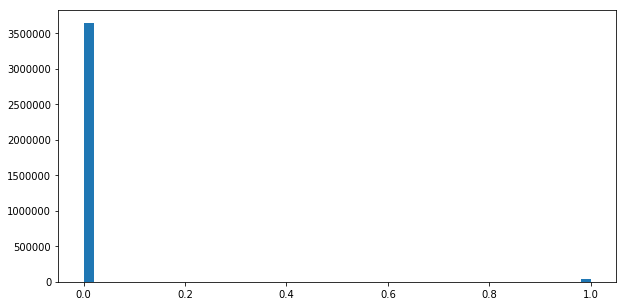

In [104]:
dup = []
for k in user_item_est:
    for i in k:
        dup.append(i)

plt.figure(figsize=(10,5))
plt.hist(dup, bins=50);

**In the lesson we used ratings, while in this case we only know if an user has interacted with an article or not. This can supose an advantge in the sense that we can use the classic SVD method because we don't have null values, we don't need to apply the FunkSVD method. In this case we are not going to predict a rate (a value between 0 and 10 for example), instead of that, we are trying to predict if a user would be interested in an article (1) or not (0).**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

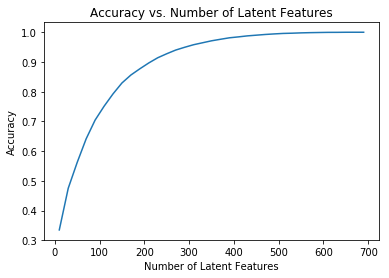

In [105]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.`  From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [106]:
df_train = df.head(40000)
df_test = df.tail(5993)

In [107]:
df_train.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [108]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create the user_item_train dataframe
    user_item_train =  df_train[['user_id', 'article_id']]
    user_item_train['interact'] = 1
    user_item_train = user_item_train.groupby(['user_id', 'article_id'])['interact'].max().unstack()
    user_item_train.fillna(0, inplace=True)
    
    # create the user_item_test dataframe
    user_item_test =  df_test[['user_id', 'article_id']]
    user_item_test['interact'] = 1
    user_item_test = user_item_test.groupby(['user_id', 'article_id'])['interact'].max().unstack()
    user_item_test.fillna(0, inplace=True)
    
    # get two lists with index and columns of user_item_test to obtain test_idx and test_arts
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

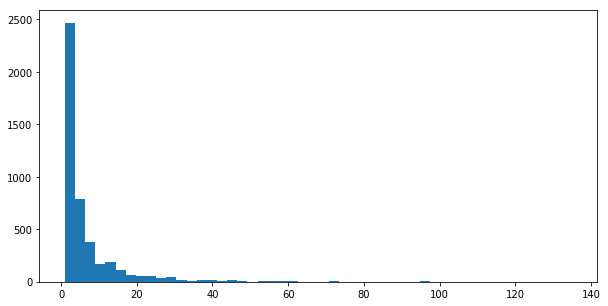

In [109]:
plt.figure(figsize=(10,5))
plt.hist(user_item_train.sum(axis=1), bins=50);

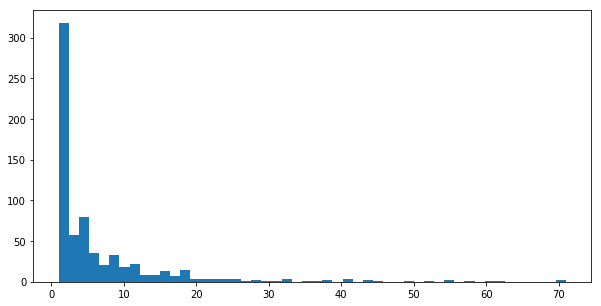

In [110]:
plt.figure(figsize=(10,5))
plt.hist(user_item_test.sum(axis=1), bins=50);

* Total number of users in the test dataset

In [111]:
len(test_idx)

682

* Total number of articles in the test dataset

In [112]:
len(test_arts)

574

* We can make predictions for those users in the test dataset that have also data in the train dataset. The users that appear in the test dataset and not in the train dataset are new users.

In [113]:
train_idx = list(user_item_train.index)
test_user_idx_in_train = [x for x in test_idx if x in train_idx]
len(test_user_idx_in_train)

20

* It happens the same with the articles.

In [114]:
train_arts = list(user_item_train.columns)
test_arts_in_train = [x for x in test_arts if x in train_arts]
len(test_arts_in_train)

574

In [115]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [116]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [117]:
u_test = u_train[user_item_train.index.isin(test_idx),:]
u_test.shape

(20, 714)

In [118]:
vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]
vt_test.shape

(714, 574)

In [119]:
user_item_test_pred = user_item_test[user_item_test.index.isin(test_user_idx_in_train)]

In [120]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [121]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []

data = []
result = pd.DataFrame(columns = ['train_test', 'latent_features', 'value', 'precision', 'recall', 'f1-score', 'support'])

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k,:]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, 
                                                  s_train_new), 
                                           vt_train_new)).astype(int)
    
    # apply the method classification_report to compare the values in the user_item_train estimation matrix
    # and the actual user_item_train. We get the values for precision, recall and f1-score for the value 0 and 1
    class_report = classification_report(user_item_est_train.flatten(), 
                                         user_item_train.astype(int).values.flatten(), 
                                         output_dict = True)
    
    data = ['train' , k, 0, 
            class_report['0']['precision'], 
            class_report['0']['recall'],
            class_report['0']['f1-score'],
            class_report['0']['support']]
            #class_report['accuracy']]
    
    s = pd.Series(data, index=result.columns)
    result = result.append(s, ignore_index=True)
    
    data = ['train' , k, 1, 
            class_report['1']['precision'], 
            class_report['1']['recall'],
            class_report['1']['f1-score'],
            class_report['1']['support']]
           # class_report['accuracy']]

    s = pd.Series(data, index=result.columns)
    result = result.append(s, ignore_index=True)
    
    # take dot product
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, 
                                                 s_train_new), 
                                          vt_test_new)).astype(int)
    
    # apply the method classification_report to compare the values in the user_item_test estimation matrix
    # and the actual user_item_test. We get the values for precision, recall and f1-score for the value 0 and 1
    class_report = classification_report(user_item_est_test.flatten(), 
                                         user_item_test_pred.astype(int).values.flatten(), 
                                         output_dict = True)
    
    data = ['test' , k, 0, 
            class_report['0']['precision'], 
            class_report['0']['recall'],
            class_report['0']['f1-score'],
            class_report['0']['support']]
           # class_report['accuracy']]
    
    s = pd.Series(data, index=result.columns)
    result = result.append(s, ignore_index=True)
    
    data = ['test' , k, 1, 
            class_report['1']['precision'], 
            class_report['1']['recall'],
            class_report['1']['f1-score'],
            class_report['1']['support']]
            #class_report['accuracy']]

    s = pd.Series(data, index=result.columns)
    result = result.append(s, ignore_index=True)
  

C:\Users\jesus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We have all the results obtained before saved in a dataframe. We will use this dataframe to see the behavior in some plots.

In [122]:
result.head()

,train_test,latent_features,value,precision,recall,f1-score,support
0,train,10,0,0.999813,0.991905,0.995843,3199762
1,train,10,1,0.113347,0.851823,0.200072,3894
2,test,10,0,0.996448,0.981802,0.989071,11430
3,test,10,1,0.045872,0.200000,0.074627,50
4,train,30,0,0.999896,0.993577,0.996726,3194643


First we are going to take a look to the accuracy predicting the ones. This is the value interesting to us, how well we can predict if a user is going to read an article or not.

In [123]:
result_train_1 = result[(result.value == 1) & (result.train_test == 'train')]
result_test_1 = result[(result.value == 1) & (result.train_test == 'test')]

First we are going to see the  precision. True positives / All positives predicted.

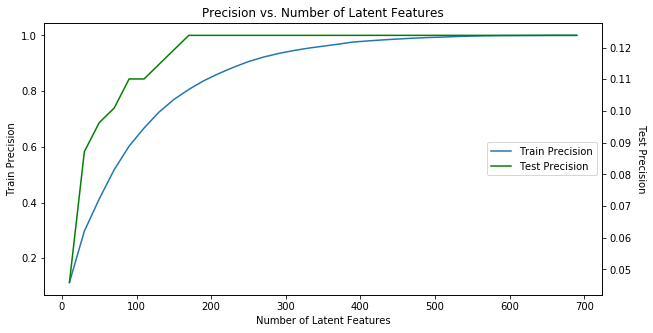

In [124]:

fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_1['latent_features'], result_train_1['precision'], label="Train Precision");
ax2.plot(result_test_1['latent_features'], result_test_1['precision'], color='green', label="Test Precision");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Precision vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Precision');
ax2.set_ylabel('Test Precision', rotation=270, labelpad=15);


In both cases, train and test, the precentage increases with the number of features.  With more features the number of false positives decreases.

Now we are going to see what happen with the recall: True positives / All actual positives.

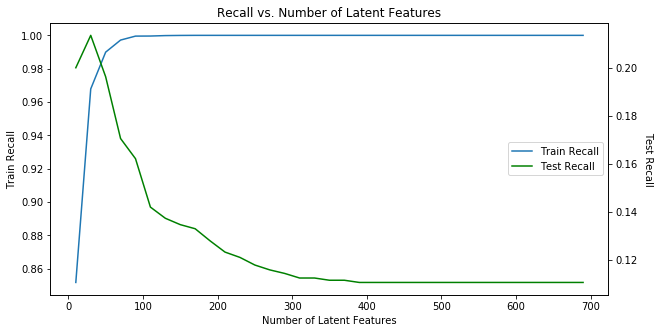

In [125]:
fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_1['latent_features'], result_train_1['recall'], label="Train Recall");
ax2.plot(result_test_1['latent_features'], result_test_1['recall'], color='green', label="Test Recall");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Recall vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Recall');
ax2.set_ylabel('Test Recall', rotation=270, labelpad=15);


If we increase the number of features we have a better beavior in the train dataset, but not in the test dataset.

Finally we are going to depict the f1-score that takes into a account the values of frecison and recall:

 ${\displaystyle F_{1}=\left({\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}\right)=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$

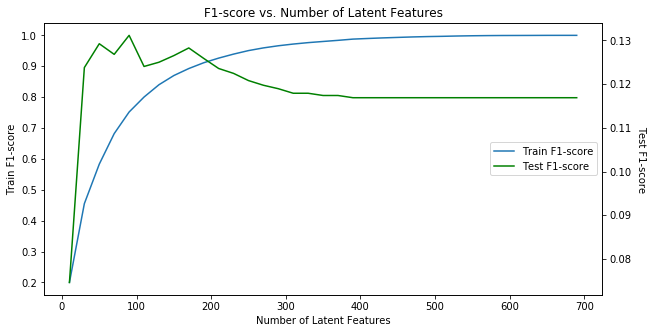

In [126]:
fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_1['latent_features'], result_train_1['f1-score'], label="Train F1-score");
ax2.plot(result_test_1['latent_features'], result_test_1['f1-score'], color='green', label="Test F1-score");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('F1-score vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train F1-score');
ax2.set_ylabel('Test F1-score', rotation=270, labelpad=15);


In [127]:
result_test_1.sort_values(by = ['f1-score'], ascending = False).head()

,train_test,latent_features,value,precision,recall,f1-score,support
19,test,90,1,0.110092,0.162162,0.131148,148
11,test,50,1,0.096330,0.196262,0.129231,107
35,test,170,1,0.123853,0.133005,0.128266,203
15,test,70,1,0.100917,0.170543,0.126801,129
31,test,150,1,0.119266,0.134715,0.126521,193


We can see that teh best option is to choose 90 latent features. Anyway the result is not very good.

We have a 11% in the precision, a 16% in the recall and 13% in the f1-score.

We are going to draw also the results for the value 0, but these are not so relevant, since the dataset is highly imbalanced and most of the values are 0 it is easy to have good results. Furthermore, we are not interested in predict which articles a user will not read.

In [128]:
result_train_0 = result[(result.value == 0) & (result.train_test == 'train')]
result_test_0 = result[(result.value == 0) & (result.train_test == 'test')]

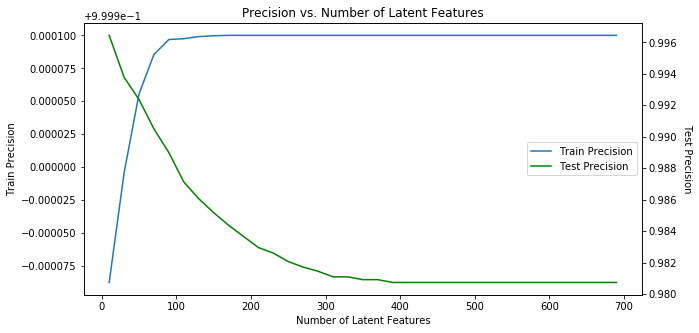

In [129]:
fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_0['latent_features'], result_train_0['precision'], label="Train Precision");
ax2.plot(result_test_0['latent_features'], result_test_0['precision'], color='green', label="Test Precision");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Precision vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Precision');
ax2.set_ylabel('Test Precision', rotation=270, labelpad=15);

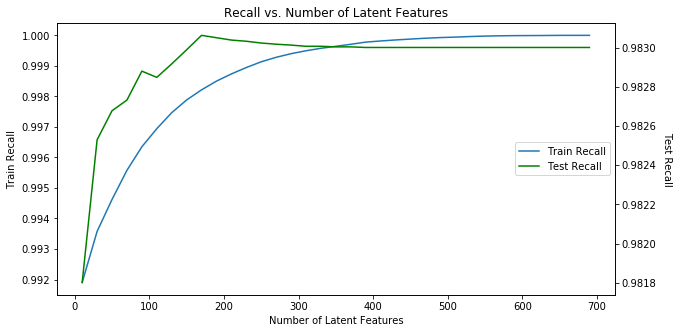

In [130]:
fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_0['latent_features'], result_train_0['recall'], label="Train Recall");
ax2.plot(result_test_0['latent_features'], result_test_0['recall'], color='green', label="Test Recall");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Recall vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Recall');
ax2.set_ylabel('Test Recall', rotation=270, labelpad=15);


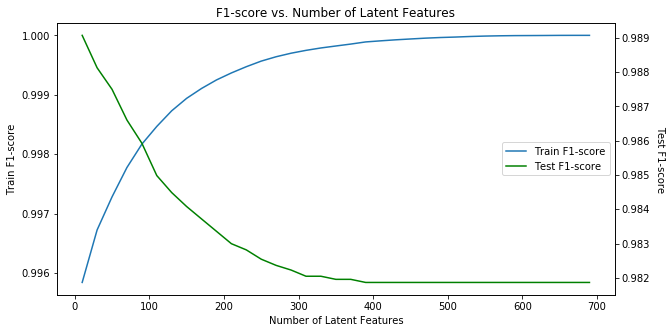

In [131]:
fig, ax1 = plt.subplots(figsize = (10,5));
ax2 = ax1.twinx();

ax1.plot(result_train_0['latent_features'], result_train_0['f1-score'], label="Train F1-score");
ax2.plot(result_test_0['latent_features'], result_test_0['f1-score'], color='green', label="Test F1-score");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('F1-score vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train F1-score');
ax2.set_ylabel('Test F1-score', rotation=270, labelpad=15);


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The dataset is strongly imbalanced, so the best option is to choose the best f1-score for the value 1. Anyway, given the high number of articles (574) and the low number of useres (20), the final result is not very good. We only can achieve a f1-score of 0.13 with 90 latent features. To measure the global accuracy in this case is useless because almost all the values are 0 so it is easy to make a good prediction of them. Even if we have predicted that no user will read any article we will probably have a good result for the accuracy.

This low result does not mean that the system is necessaraly bad. The users can not have read an article for many circunstances, not only because they don't like it. Maybe we will need to have a bigger test dataset, the fact that we only can make predictions for 20 users means that maybe the train and test dataset are not correctly dimensioned, they should have more users and articles in common.

The only method I can think of to determine if the recommendations are good or not is to use A/B testing. We could compare the new system with the old one choosing the correct metrics. Maybe the increase of interactions could be a good metric. Or maybe implement a system with ratings to get some feedback from the users, in that way we could compare the ratings given to articles recommended  with the two methods.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [132]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0